In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import sys
sys.path.append("../../class")
from Flow_class import Flow
from Prova_transport_class import Transport

In [2]:
Nx=4
Ny=4

In [3]:
gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)

In [4]:
parameter={"aperture":1e-3,
          "fracture_perm":1e4,
          "perm":1,
          "f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

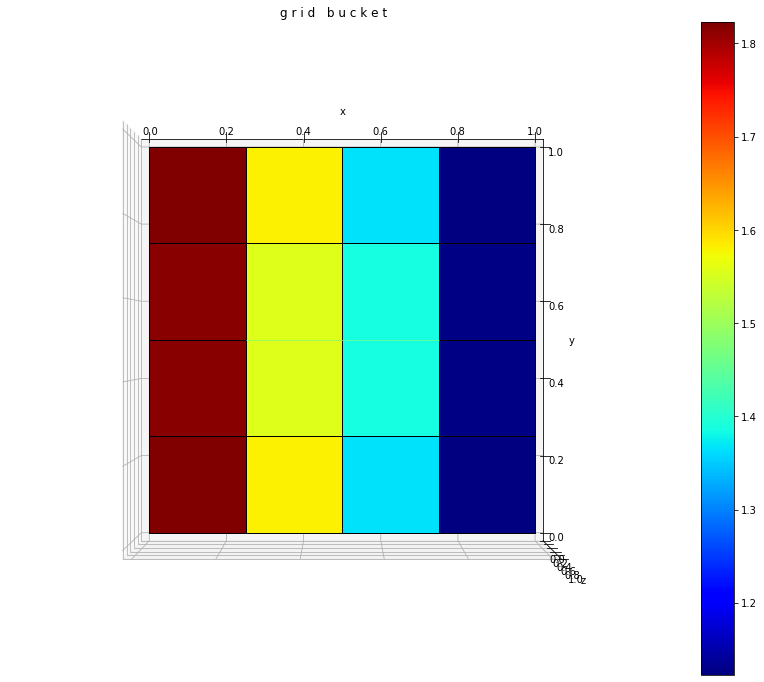

In [5]:
flow=Flow(gb,domain,parameter)
flow.add_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [6]:
parameter={
    "aperture":1e-4,
    "por":0.2,
    "por_frac":0.8,
    "time_step":1 / 60,
    "t_max":1 /3,
    "bc_value":[1.0,0.0],
    "bc_type":['dir','dir'],
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)
transport.set_data()
transport.get_flux()
transport.discretize()
lhs,rhs_source_adv,rhs_mass,assembler=transport.get_transport_lhs_rhs()

In [8]:
print("tracer_size:")
print(rhs_source_adv.size)

tracer_size:
22


In [9]:
save_every = 1
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer = np.zeros(rhs_source_adv.size)
assembler.distribute_variable(
    tracer, variable_names=[transport.grid_variable,transport.mortar_variable]
)


# Exporter
exporter = pp.Exporter(gb, file_name="tracer", folder_name="Tracer")
export_fields = ["tracer"]
IEsolver = sps.linalg.factorized(lhs)

/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


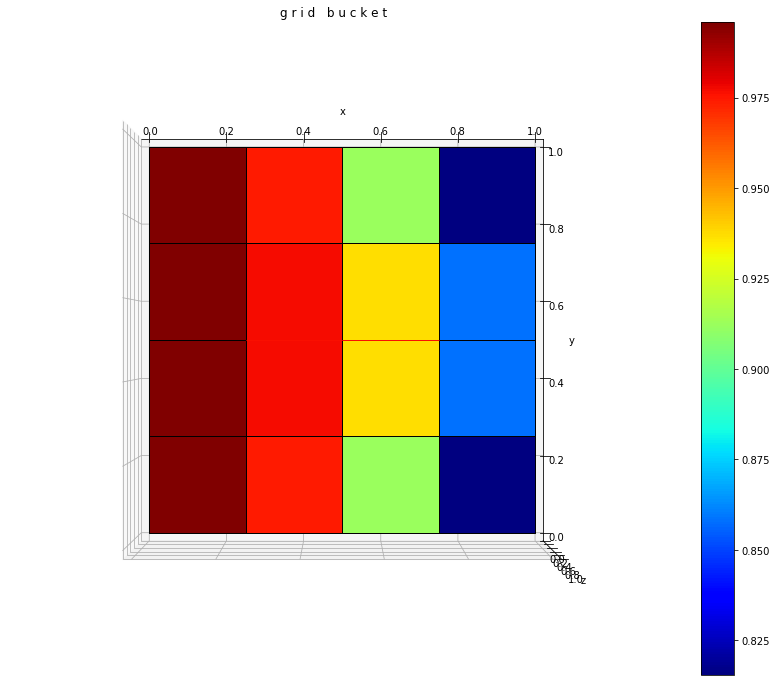

In [10]:
for i in range(n_steps):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler.distribute_variable(
        tracer,
        variable_names=[transport.grid_variable,transport.mortar_variable],
    )
        exporter.write_vtu(export_fields, time_step=int(i // save_every))
    tracer = IEsolver(rhs_mass * tracer + rhs_source_adv)

    
exporter.write_vtu(export_fields, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter.write_pvd(time_steps)
transport.plot_tracer()